# Ocean BRDF Visualization

Before being able to visualize the ocean BRDF we need some utilities.

In [1]:
# Mitsuba Stuff
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

mi.set_variant("llvm_ad_rgb")

In [2]:
# Utility functions
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

def convert_wind_speed(wind_speed):
    return max(0.0, min(1.0, wind_speed / 38.0))

In [3]:
# Plotting
def plot_flat(brdf_data):
    # Plot values for spherical coordinates
    fig, ax = plt.subplots(figsize=(8, 4))

    im = ax.imshow(brdf_data, extent=[0, 2 * np.pi, np.pi, 0], cmap='turbo')

    ax.set_xlabel(r'$\phi_o$', size=10)
    ax.set_xticks([0, dr.pi, dr.two_pi])
    ax.set_xticklabels(['0', '$\\pi$', '$2\\pi$'])
    ax.set_ylabel(r'$\theta_o$', size=10)
    ax.set_yticks([0, dr.pi / 2, dr.pi])
    ax.set_yticklabels(['0', '$\\pi/2$', '$\\pi$']);
    
    # Show
    plt.colorbar(im)
    plt.show()

def plot_polar(azimuths, zeniths, brdf_data):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(azimuths, zeniths, c=brdf_data, cmap='turbo', s=1)
    ax.grid(False)
    ax.set_yticklabels([])
    cbar = plt.colorbar(ax.scatter(azimuths, zeniths, c=brdf_data, cmap='turbo', s=1))
    ax.set_ylim(0, np.pi / 2)
    
    # Show
    plt.show()

def plot_polar_tricf(azimuths, zeniths, brdf_data, levels=16):
    # Transform zenith into degree
    zeniths_deg = np.rad2deg(zeniths)

    # Create triangulation
    x = zeniths_deg * np.cos(azimuths)
    y = zeniths_deg * np.sin(azimuths)
    triangles = tri.Triangulation(x, y)

    # Make plot
    fig = plt.figure(figsize=(6,6))
    rect = [0, 0, 1, 1]

    # Main plot in Cartesian coordinates
    ax_cartesian = fig.add_axes(rect, frameon=False, aspect='equal')
    ax_cartesian.axis('off')
    ctr = ax_cartesian.tricontourf(triangles, brdf_data, levels=levels, cmap='turbo')

    # Show the contours
    #ax_cartesian.tricontour(triangles, brdf_data_t, levels=levels, colors='k', linewidths=0.5)

    # Match limits with the full zenith range
    ax_cartesian.set_xlim([-90, 90])
    ax_cartesian.set_ylim([-90, 90])

    # Polar axes
    ax_polar = fig.add_axes(rect, polar=True, facecolor="none")
    ax_polar.set_rlim([0, 90])          # Cover the full zenith value range
    ax_polar.grid(False)                # Hide the polar grid
    ax_polar.set_yticklabels([])        # No radial tick labels

    # Add the color bar (important: both axes must be adjusted)
    fig.colorbar(ctr, ax=[ax_cartesian, ax_polar])

    # Show
    plt.show()

### BRDF Visualisation

In [4]:
# BRDF Creation
bsdf = mi.load_dict({
    'type': 'oceanic_legacy',
    'wavelength': 0.5,
    'wind_speed': convert_wind_speed(10.0),
})
bsdf

OceanicLegacy[
  wavelength = UniformSpectrum[value=[0.5]]
  wind_speed = UniformSpectrum[value=[0.263158]]
]

: 

In [ ]:
# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(45.0), dr.deg2rad(0.0))

# Create grid in spherical coordinates and map it into a sphere
res = 500
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_eucl(zeniths_o, azimuths_o)

# Evaluate the BSDF
brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)

In [ ]:
# Some conversions necessary for proper plotting
brdf_data = (np.array(brdf_values)[:,0]).reshape(2 * res, res).T

# Combine zeniths, azimuths and BRDF values into a single array
zeniths_s = np.array(zeniths_o)
azimuths_s = np.array(azimuths_o)
brdf_data_s = np.array(brdf_data).T.flatten()

data = np.stack([zeniths_s, azimuths_s, brdf_data_s], axis=1)

# Remove rows where the zenith (first element) is greater than 90 degrees
data = data[data[:, 0] <= np.pi / 2]

# Extract the new values
zeniths = data[:, 0]
azimuths = data[:, 1]
brdf = data[:, 2]

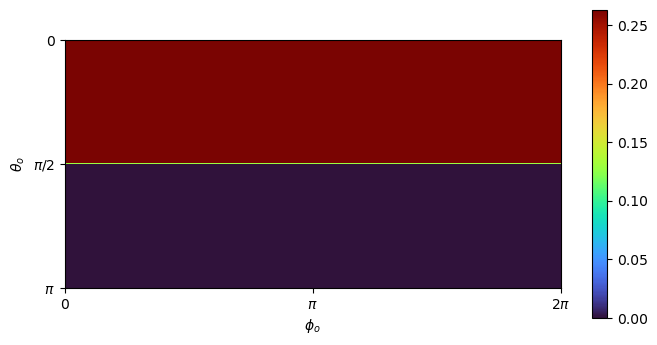

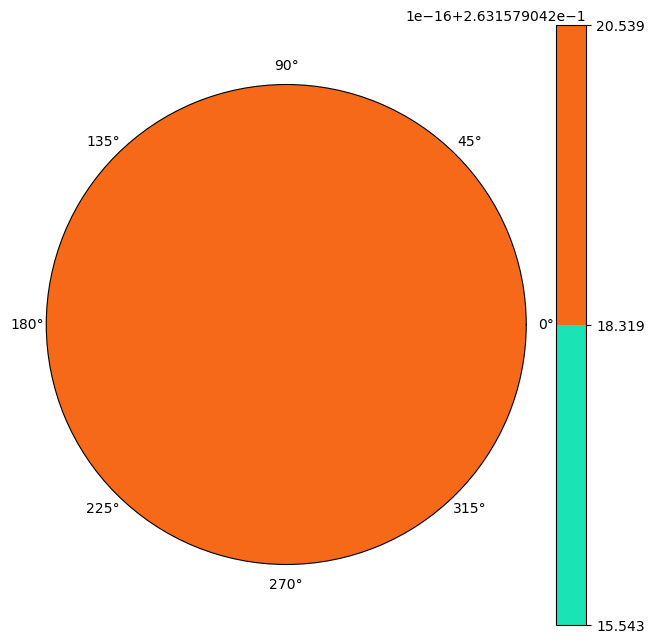

In [ ]:
plot_flat(brdf_data)
#plot_polar(azimuths, zeniths, brdf)
plot_polar_tricf(azimuths, zeniths, brdf, levels=256)